In [1]:
import pandas as pd
import nltk
import string
import re
pd.set_option("display.max_colwidth",100)

In [2]:
# Read the data
data = pd.read_csv("SMSSpamCollection.tsv",sep="\t")
data.columns=['label','body_text']
data.head()

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
1,ham,"Nah I don't think he goes to usf, he lives around here though"
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...


# Feature Engineering

In [3]:
# Hypothesis: Length of text in Spam msgs are higher 
# Feature: Text length

data['text_length'] = data['body_text'].apply(lambda x: len(x)-x.count(" "))
data.head()

,label,body_text,text_length
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,128
1,ham,"Nah I don't think he goes to usf, he lives around here though",49
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.,62
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,135


In [4]:
# Hypothesis: Spam messages have more punctuations
# Feature: % of punctuations

def count_punct(text):
    tot = sum(1 for char in text if char in string.punctuation)
    return round(tot/(len(text)-text.count(" ")),3)*100

data['punc'] = data['body_text'].apply(lambda x:count_punct(x))
data.head()

,label,body_text,text_length,punc
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,128,4.7
1,ham,"Nah I don't think he goes to usf, he lives around here though",49,4.1
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.,62,3.2
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,135,4.4


# Feature Evaluation

In [5]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

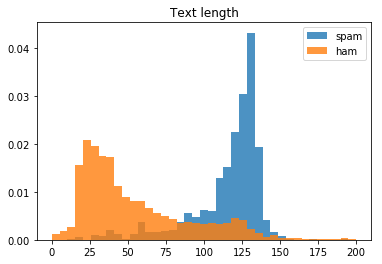

In [6]:
# Check the distribution of text length feature.
bins = np.linspace(0,200,40)
pyplot.hist(data[data['label']=='spam']['text_length'],bins,normed=True,alpha=0.8,label='spam')
pyplot.hist(data[data['label']=='ham']['text_length'],bins,normed=True,alpha=0.8,label='ham')
pyplot.legend(loc='best')
pyplot.title("Text length")
pyplot.show()

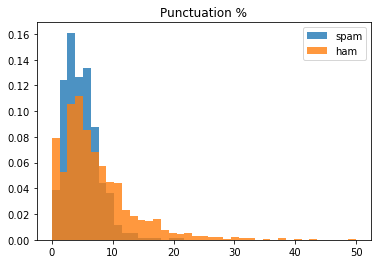

In [7]:
# Check the distribution for punctuation % feature 
bins = np.linspace(0,50,40)
pyplot.hist(data[data['label']=='spam']['punc'],bins,normed=True,alpha=0.8,label='spam')
pyplot.hist(data[data['label']=='ham']['punc'],bins,normed=True,alpha=0.8,label='ham')
pyplot.legend(loc='best')
pyplot.title("Punctuation %")
pyplot.show()

# Feature Transformation

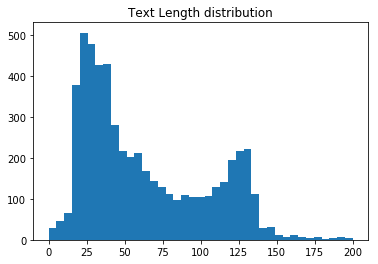

In [8]:
# Check of the distribution is skewed
bins = np.linspace(0,200,40)
pyplot.hist(data['text_length'],bins)
pyplot.title("Text Length distribution")
pyplot.show()

# Not good for transformation since it is bimodal. 
# Ideal candidates are the ones which are skewed, as a long tail and outliers can cause a model to be biased, hence we use transformation.

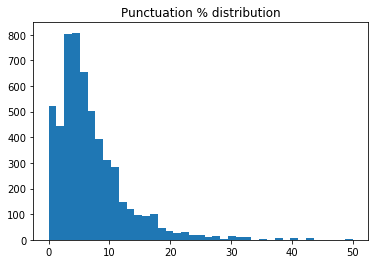

In [9]:
bins = np.linspace(0,50,40)
pyplot.hist(data['punc'],bins)
pyplot.title("Punctuation % distribution")
pyplot.show()

# Good Candidate as it is skewed

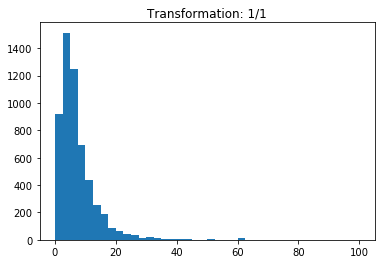

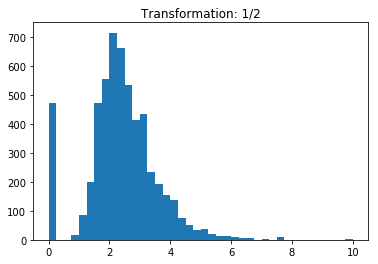

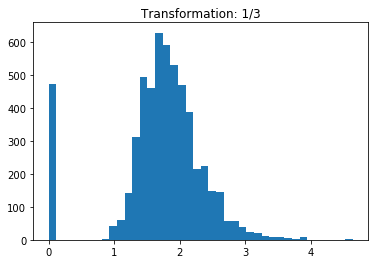

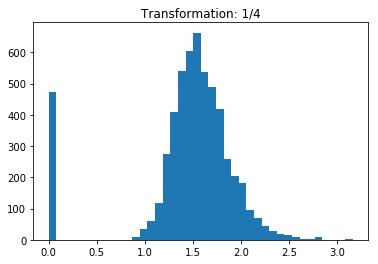

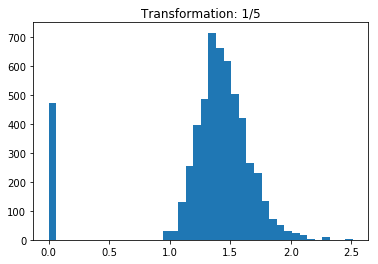

In [10]:
# Box Cox Transformation

for i in [1,2,3,4,5]:
    pyplot.hist((data['punc'])**(1/i),bins=40)
    pyplot.title("Transformation: 1/{}".format(str(i)))
    pyplot.show()
    
# Bar at 0 represent the 0's in the data which are without punctuation
# 0's remain 0's after transformation

# Data Wrangling

In [11]:
# For stopwords and stemming
stopwords = nltk.corpus.stopwords.words('english')
pa = nltk.PorterStemmer()

In [12]:
# Remove punctuation, tokenize, remove stop words and stemming

def clean_text(text):
    text = "".join([char for char in text if char not in string.punctuation]) # remove punctuation
    tokens = re.split("\W+",text)                                             # tokenize
    text = [pa.stem(word) for word in tokens if word not in stopwords]        # remove stop words and stem
    return text
    
# data['cleaned'] = data['body_text'].apply(lambda x:clean_text(x.lower()))
# data.head()

In [13]:
# TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(analyzer = clean_text)
x = vec.fit_transform(data['body_text'])           # x returnes a sparse matrix 

X_features = pd.concat([data['text_length'],data['punc'],pd.DataFrame(x.toarray())],axis=1) # for ML, need a df without labels
X_features.head()

,text_length,punc,0,1,2,3,4,5,6,7,...,8324,8325,8326,8327,8328,8329,8330,8331,8332,8333
0,128,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,135,4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
tfidf_df = pd.DataFrame(x.toarray()) # convert sparse to array(add 0's) and create a dataframe
tfidf_df.columns = vec.get_feature_names()
tfidf_df.head()

,,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,...,zoe,zogtoriu,zoom,zouk,zyada,Ü,é,ü,üll,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Machine Learning 
###  1) Random forest

In [15]:
# ---------------------
#  Using k-Fold
# ---------------------

In [16]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

kf_clf = RandomForestClassifier(n_jobs=-1) # this process can run in ll'el, so use -1 to imporove speed
k_fold = KFold(n_splits=5)
cross_val_score(kf_clf,X_features,data['label'],cv=k_fold,scoring="accuracy",n_jobs=-1)

array([ 0.96768402,  0.97576302,  0.97304582,  0.96136568,  0.97124888])

In [17]:
# -------------------------
# Using train_text_split
# -------------------------

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_features,data['label'],test_size=0.2)

clf = RandomForestClassifier(n_estimators=50,max_depth=20,n_jobs=-1)
rf_model = clf.fit(X_train, y_train)
sorted(zip(rf_model.feature_importances_,X_train.columns),reverse=True)[0:5]

[(0.052638332726557754, 'text_length'),
 (0.048641674515164775, 7574),
 (0.034379948598313323, 3348),
 (0.02298393561392453, 5006),
 (0.020152344651231752, 2243)]

In [20]:
y_pred = rf_model.predict(X_test)
precision, recall, fscore, support = score(y_test,y_pred,pos_label="spam",average="binary")
print("Precision: {} / Recall: {} / Accuracy: {}".format(round(precision,3),
                                                        round(recall,3),
                                                       round((y_pred==y_test).sum()/len(y_pred),3)))

Precision: 1.0 / Recall: 0.57 / Accuracy: 0.945


In [21]:
# ---------------------
# Using GridSearchCV
# ---------------------

In [22]:
# Gridsearchcv to get the best parameters

from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
param = {'n_estimators':[10,150,300],
        'max_depth':[30,60,90,None]}

gs = GridSearchCV(clf,param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_features,data['label'])
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False) [0:5]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,2.527241,0.124268,0.974313,0.998114,90,10,"{'max_depth': 90, 'n_estimators': 10}",1,0.977578,0.998652,...,0.974843,0.998204,0.972147,0.997081,0.973944,0.998204,0.090319,0.020201,0.001865,0.000542
11,42.894699,0.334100,0.974313,1.000000,None,300,"{'max_depth': None, 'n_estimators': 300}",1,0.977578,1.000000,...,0.973046,1.000000,0.967655,1.000000,0.975741,1.000000,4.426194,0.044310,0.003716,0.000000
10,23.422164,0.255517,0.974133,1.000000,None,150,"{'max_depth': None, 'n_estimators': 150}",3,0.973991,1.000000,...,0.973944,1.000000,0.970350,1.000000,0.974843,1.000000,0.177652,0.029011,0.002300,0.000000
8,43.681387,0.355251,0.973954,0.999282,90,300,"{'max_depth': 90, 'n_estimators': 300}",4,0.976682,0.999551,...,0.974843,0.998877,0.967655,0.999775,0.972147,0.999102,0.886661,0.009428,0.003775,0.000330
7,22.180884,0.265890,0.973774,0.999192,90,150,"{'max_depth': 90, 'n_estimators': 150}",5,0.976682,0.999326,...,0.973944,0.998653,0.966757,0.999775,0.974843,0.999102,0.256376,0.031123,0.003663,0.000365


### 2) Gradient Boosing

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
gb = GradientBoostingClassifier()
params = {'n_estimators': [100,150],
          'max_depth': [7,11,15]}

gs = GridSearchCV(gb,params,cv=5,n_jobs=-1) # here n_jobs runs on different subsets and params settings in ll'el unlike the model in Randomforest
cv_fit = gs.fit(X_features,data['label'])
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score',ascending=False)[0:5]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,249.256041,0.209839,0.971978,1.0,7,150,"{'max_depth': 7, 'n_estimators': 150}",1,0.969507,1.0,...,0.970350,1.0,0.969452,1.0,0.969452,1.0,2.091407,0.008359,0.004589,0.0
3,396.853857,0.239559,0.971439,1.0,11,150,"{'max_depth': 11, 'n_estimators': 150}",2,0.968610,1.0,...,0.967655,1.0,0.972147,1.0,0.969452,1.0,6.381485,0.012318,0.004221,0.0
2,274.103995,0.215422,0.971080,1.0,11,100,"{'max_depth': 11, 'n_estimators': 100}",3,0.966816,1.0,...,0.969452,1.0,0.972147,1.0,0.969452,1.0,4.131412,0.030696,0.003642,0.0
4,368.598297,0.213828,0.971080,1.0,15,100,"{'max_depth': 15, 'n_estimators': 100}",3,0.969507,1.0,...,0.969452,1.0,0.971249,1.0,0.967655,1.0,4.523294,0.005870,0.003423,0.0
5,479.738087,0.212831,0.971080,1.0,15,150,"{'max_depth': 15, 'n_estimators': 150}",3,0.967713,1.0,...,0.969452,1.0,0.973046,1.0,0.969452,1.0,62.622968,0.023266,0.002906,0.0


#### In this notebook we have created 2 features, explored them , found the best hyper-parameters for random forest and gradient boosting algorithms